In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from typing import List, Set, Dict, Tuple, Union
import warnings

warnings.filterwarnings('ignore')
Combination = Tuple[int, ...]
RGB = Tuple[Union[int, float], ...]

In [2]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

from imblearn.under_sampling import ClusterCentroids
from imblearn.under_sampling import CondensedNearestNeighbour
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.under_sampling import RepeatedEditedNearestNeighbours
from imblearn.under_sampling import AllKNN
from imblearn.under_sampling import InstanceHardnessThreshold
from imblearn.under_sampling import NearMiss
from imblearn.under_sampling import NeighbourhoodCleaningRule
from imblearn.under_sampling import OneSidedSelection
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import RandomUnderSampler

In [3]:
# BALANCED_OBF_METHODS_RATIO_150_FILENAME: str = r"D:\Obfuscation\data\datasets\balanced\BALANCED_OBF_METHODS_RATIO_150_DATASET.csv"
# BALANCED_OBF_METHODS_RATIO_200_FILENAME: str = r"D:\Obfuscation\data\datasets\balanced\BALANCED_OBF_METHODS_RATIO_200_DATASET.csv"
# BALANCED_OBF_METHODS_RATIO_2000_FILENAME: str = r"D:\Obfuscation\data\datasets\balanced\BALANCED_OBF_METHODS_RATIO_2000_DATASET.csv"

In [3]:
BALANCED_DATASET_770_FILENAME: str = r"D:\Obfuscation\data\datasets\balanced\BALANCED_DATASET_770.csv"
BALANCED_DATASET_770_WITHOUT_CMD_FILENAME: str = r"D:\Obfuscation\data\datasets\balanced\BALANCED_DATASET_770_WITHOUT_CMD.csv"
    
X_LOWER_INDEX: int = 2  # included
X_UPPER_INDEX: int = -2  # excluded

In [4]:
def separate_obj_indexes(Y: pd.Series) -> Dict[str, List[int]]:
    clear_indexes: List[int] = []
    for i in range(len(Y)):
        if Y.iloc[i] == 0:
            clear_indexes.append(i)
    obf_indexes: List[int] = list(set(np.arange(0, len(Y)))-set(clear_indexes))
    indexes: Dict[str, List[int]] = {
        "clear": clear_indexes,
        "obfuscated": obf_indexes,
    }
    return indexes

In [5]:
def annotate_overlapping_obf_commands(ax, Y: pd.Series, commands: List[str], embedding, eps: float = 0.1) -> List[Tuple[str, str]]:
    indexes: Dict[str, List[int]] = separate_obj_indexes(Y)
    clear_indexes, obf_indexes = indexes.get("clear", []), indexes.get("obfuscated", [])
    
    overlapping_commands: List[Tuple[str, str]] = []
    
    x_clear: List[float] = embedding[clear_indexes, 0]
    y_clear: List[float] = embedding[clear_indexes, 1]
    x: List[float] = embedding[obf_indexes, 0]
    y: List[float] = embedding[obf_indexes, 1]
    
    for i, obf_index in enumerate(obf_indexes):
        for j, clear_index in enumerate(clear_indexes):
            if abs(x[i] - x_clear[j]) <= eps and abs(y[i] - y_clear[j]) <= eps:
                ax.annotate(obf_index, xy=(x[i], y[i]))
                overlapping_commands.append(tuple([
                            f"Clear command № {clear_index}: {commands[clear_index]}",
                            f"Obfuscated command № {obf_index}: {commands[obf_index]}"
                        ]
                    )
                )
                break
    return overlapping_commands

In [6]:
def plot_2d(ax, X: pd.DataFrame, Y: pd.Series, commands: List[str], obfuscation_combinations: List[int], reduction_transformer, annotate: bool = False, n_components=None, title: str = "", eps: float = 0.1):
    embedding = []
    if n_components:
        tranformer_embedding = reduction_transformer(n_components=n_components, random_state=42).fit_transform(X)

        tsne_object = TSNE(n_components=2, verbose=0, random_state=42)
        embedding = tsne_object.fit_transform(tranformer_embedding)
    else:
        embedding = reduction_transformer(n_components=2, random_state=42).fit_transform(X)
        
    scatter = ax.scatter(embedding[:, 0], embedding[:, 1], c=obfuscation_combinations, cmap='tab20')
    
    overlapping_commands: List[Tuple[str, str]] = []
        
    if annotate:
        overlapping_commands = annotate_overlapping_obf_commands(ax=ax, Y=Y, commands=commands, embedding=embedding, eps=eps)
        
    ax.set_title(title)
    ax.legend(handles=scatter.legend_elements()[0], labels=set(obfuscation_combinations), ncol=3)
    ax.grid(True)
    
    return (ax, overlapping_commands) if annotate else ax

In [7]:
def scale_data(scaler_class, X):
    scaler = scaler_class()
    scaler = scaler.fit(X)
    X_scale = scaler.transform(X)
    return scaler, X_scale

In [8]:
def show_imbalanced_2d_plot(imbalance_obj, X, Y, reduction_transformer, n_components=None, annotate: bool = False):
    X_resampled, y_resampled = imbalance_obj.fit_resample(X, Y)
    print("Default data's resample was completed successfully!")
    
    scaler_minmax, X_scaled_minmax = scale_data(MinMaxScaler, X)
    X_resampled_minmax, y_resampled_minmax = imbalance_obj.fit_resample(X_scaled_minmax, Y)
    print("MinMax scaled data's resample was completed successfully!")
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
        
    plot_2d(ax=ax1,
            X=X_scaled_minmax, 
            Y=Y, 
            n_components=n_components,
            reduction_transformer=reduction_transformer,
            title=f'MinMax нормировка БЕЗ сэмплирования\n {n_components} компонент',
            annotate=annotate)
    plot_2d(ax=ax2, 
            X=X_resampled_minmax, 
            Y=y_resampled_minmax, 
            n_components=n_components, 
            reduction_transformer=reduction_transformer,
            title=f'MinMax нормировка {imbalance_obj} \n {n_components} компонент',
            annotate=annotate)

    return imbalance_obj, X_resampled, y_resampled, X_resampled_minmax, y_resampled_minmax

In [10]:
# def parse_combinations(y_vector: pd.Series) -> List[Combination]:
#     result: List[Combination] = [tuple(map(int, str.strip(combination, "()").split(', '))) for combination in y_vector]
#     return result

In [11]:
# color_to_combination: Dict[Combination, RGB] = {
#     (0, 0, 0, 0, 0): (0, 255, 0),  # green
#     (0, 0, 0, 0, 1): (0, 0, 255),  # blue
#     (0, 0, 0, 1, 0): (223, 255, 0),  # chartreuse
#     (0, 0, 0, 1, 1): (255, 191, 0),  # amber
#     (0, 0, 1, 0, 0): (255, 127, 80),  # coral
#     (0, 0, 1, 1, 0): (222, 49, 99),  # cerise
#     (0, 1, 0, 0, 0): (159, 226, 191),  # seafoam green
#     (0, 1, 0, 0, 1): (64, 224, 208),  # turquoise
#     (0, 1, 0, 1, 0): (100, 149, 237),  # cornflower blue
#     (0, 1, 0, 1, 1): (204, 204, 255),  # periwinkle
#     (0, 1, 1, 0, 0): (0, 0, 0),  # black
#     (0, 1, 1, 1, 0): (111, 78, 55),  # coffee
#     (0, 1, 1, 1, 1): (123, 63, 0),  # chocolate
#     (1, 0, 0, 0, 0): (204, 85, 0),  # burnt orange
#     (1, 0, 1, 0, 0): (216, 191, 216),  # thistle
# }
    
# color_to_combination_scaled: Dict[Combination, RGB] = {
#     combination: tuple([value / 255 for value in color]) for combination, color in color_to_combination.items()
# }
    
# def generate_colors_for_combinations(color_to_combination_scaled: Dict[Combination, RGB], combinations: List[Combination]) -> List[RGB]:
#     colors: List[RGB] = [color_to_combination_scaled[combination] for combination in combinations]
#     return colors

In [12]:
# balanced_150_df: pd.DataFrame = pd.read_csv(BALANCED_OBF_METHODS_RATIO_150_FILENAME)
# balanced_200_df: pd.DataFrame = pd.read_csv(BALANCED_OBF_METHODS_RATIO_200_FILENAME)

In [13]:
# print(balanced_150_df.shape)
# balanced_150_df.head()

(1953, 2711)


,command_obfuscated,AstGroupedArrayElementRangeCounts_0-10_Count,AstGroupedArrayElementRangeCounts_0-10_Percent,AstGroupedArrayElementRangeCounts_10-20_Count,AstGroupedArrayElementRangeCounts_10-20_Percent,AstGroupedArrayElementRangeCounts_20-30_Count,AstGroupedArrayElementRangeCounts_20-30_Percent,AstGroupedArrayElementRangeCounts_30-40_Count,AstGroupedArrayElementRangeCounts_30-40_Percent,AstGroupedArrayElementRangeCounts_40-50_Count,...,AstVariableNameMetrics_Length_Range,AstVariableNameMetrics_Length_Total,AstVariableNameMetrics_UpperAlphaPercent_Average,AstVariableNameMetrics_UpperAlphaPercent_Maximum,AstVariableNameMetrics_UpperAlphaPercent_Median,AstVariableNameMetrics_UpperAlphaPercent_Minimum,AstVariableNameMetrics_UpperAlphaPercent_Mode,AstVariableNameMetrics_UpperAlphaPercent_Range,obfuscated,obfuscation_methods_mask
0,ConvertFrom-String data,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,"(0, 0, 0, 0, 0)"
1,Convertto-SecureString,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,"(0, 0, 0, 0, 0)"
2,"Get-ADComputer -SearchBase ""OU=DN"" -Filter *",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,"(0, 0, 0, 0, 0)"
3,Get-ADFineGrainedPasswordPolicy -filter *,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,"(0, 0, 0, 0, 0)"
4,"Get-Content -Path ""c:windowssystem32logfilesfi...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,"(0, 0, 0, 0, 0)"


In [14]:
# print(balanced_200_df.shape)
# balanced_200_df.head()

(2603, 2711)


,command_obfuscated,AstGroupedArrayElementRangeCounts_0-10_Count,AstGroupedArrayElementRangeCounts_0-10_Percent,AstGroupedArrayElementRangeCounts_10-20_Count,AstGroupedArrayElementRangeCounts_10-20_Percent,AstGroupedArrayElementRangeCounts_20-30_Count,AstGroupedArrayElementRangeCounts_20-30_Percent,AstGroupedArrayElementRangeCounts_30-40_Count,AstGroupedArrayElementRangeCounts_30-40_Percent,AstGroupedArrayElementRangeCounts_40-50_Count,...,AstVariableNameMetrics_Length_Range,AstVariableNameMetrics_Length_Total,AstVariableNameMetrics_UpperAlphaPercent_Average,AstVariableNameMetrics_UpperAlphaPercent_Maximum,AstVariableNameMetrics_UpperAlphaPercent_Median,AstVariableNameMetrics_UpperAlphaPercent_Minimum,AstVariableNameMetrics_UpperAlphaPercent_Mode,AstVariableNameMetrics_UpperAlphaPercent_Range,obfuscated,obfuscation_methods_mask
0,$members = Import-CSV c:itadd-to-group.csv | S...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0,"(0, 0, 0, 0, 0)"
1,Clear content,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,"(0, 0, 0, 0, 0)"
2,Compare-Object,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,"(0, 0, 0, 0, 0)"
3,Convert-to-XML,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,"(0, 0, 0, 0, 0)"
4,Disable-ADAccount -Identity rallen,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,"(0, 0, 0, 0, 0)"


In [15]:
# X_150: pd.DataFrame = balanced_150_df.iloc[:, X_LOWER_INDEX:X_UPPER_INDEX]
# y_150: pd.Series = balanced_150_df.iloc[:, Y_INDEX]
# y_vector_150: pd.Series = balanced_150_df.iloc[:, Y_VECTOR_INDEX]

In [16]:
# X_200: pd.DataFrame = balanced_200_df.iloc[:, X_LOWER_INDEX:X_UPPER_INDEX]
# y_200: pd.Series = balanced_200_df.iloc[:, Y_INDEX]
# y_vector_200: pd.Series = balanced_200_df.iloc[:, Y_VECTOR_INDEX]

In [17]:
# scaler_minmax, X_150_scaled_minmax = scale_data(MinMaxScaler, X_150)
# scaler_minmax, X_200_scaled_minmax = scale_data(MinMaxScaler, X_200)

In [18]:
# obf_methods_combinations_150: List[Combination] = parse_combinations(y_vector_150)
# obf_methods_combinations_200: List[Combination] = parse_combinations(y_vector_200)

In [19]:
# colors_150: List[RGB] = generate_colors_for_combinations(color_to_combination_scaled, obf_methods_combinations_150)
# colors_200: List[RGB] = generate_colors_for_combinations(color_to_combination_scaled, obf_methods_combinations_200)

In [20]:
# commands_150: List[str] = balanced_150_df["command_obfuscated"].to_list()
# commands_200: List[str] = balanced_200_df["command_obfuscated"].to_list()

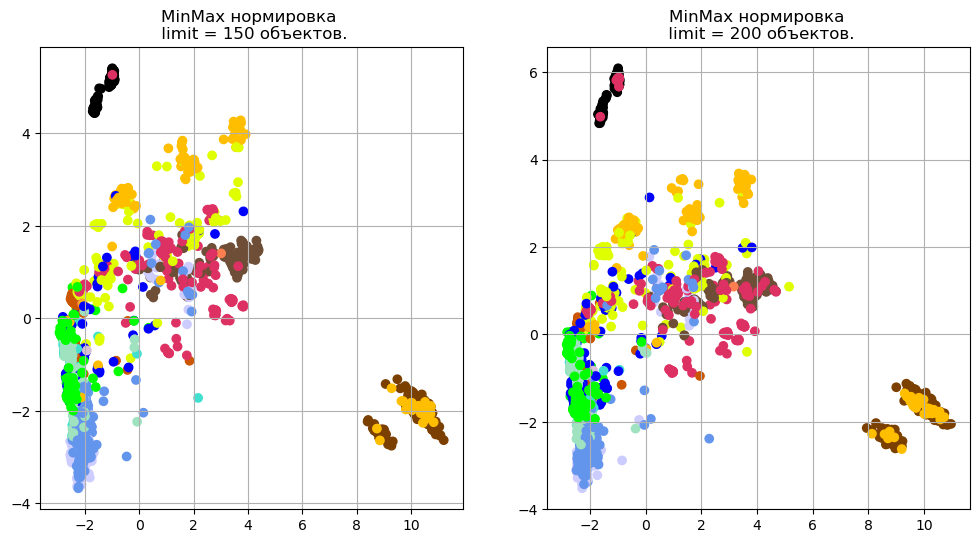

In [23]:
# f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
# plot_2d(ax1, X=X_150_scaled_minmax, Y=y_150, commands=commands_150, reduction_transformer=PCA, colors=colors_150, title="MinMax нормировка \n limit = 150 объектов.")
# plot_2d(ax2, X=X_200_scaled_minmax, Y=y_200, commands=commands_200, reduction_transformer=PCA, colors=colors_200, title="MinMax нормировка \n limit = 200 объектов.")
# None

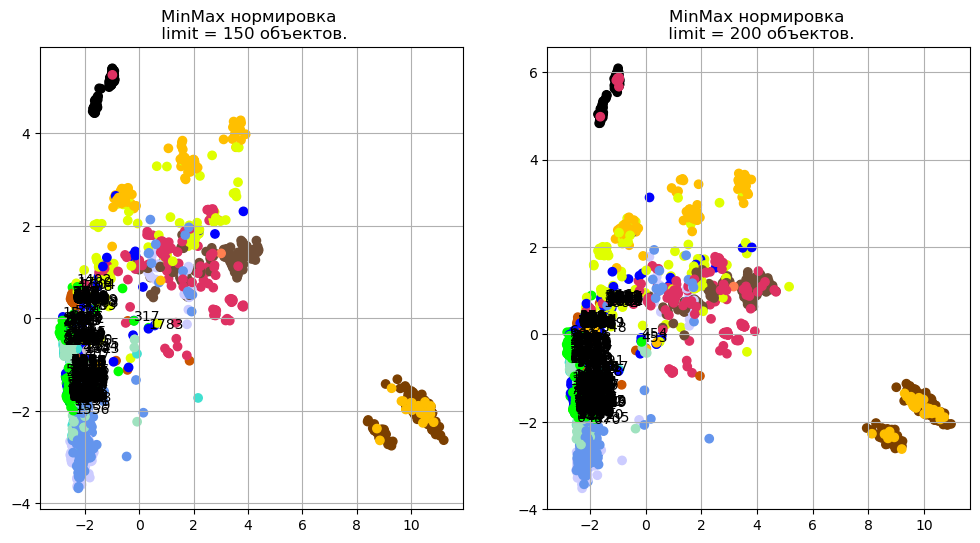

In [31]:
# f, (ax3, ax4) = plt.subplots(1, 2, figsize=(12, 6))
# ax3, overlapping_commands_150 = plot_2d(ax3, X=X_150_scaled_minmax, Y=y_150, commands=commands_150, reduction_transformer=PCA, colors=colors_150, title="MinMax нормировка \n limit = 150 объектов.", annotate=True)
# ax4, overlapping_commands_200 = plot_2d(ax4, X=X_200_scaled_minmax, Y=y_200, commands=commands_200, reduction_transformer=PCA, colors=colors_200, title="MinMax нормировка \n limit = 200 объектов.", annotate=True)


In [30]:
# for correct_command, obf_command in overlapping_commands_150:
#     print(correct_command, obf_command, sep='\n', end='\n\n')

Correct command № 12: Unlock-ADAccount âIdentity john.smith
Obfuscated command № 86: cmd  /c "set   gsd= $members = Import-CSV c:itadd-to-group.csv ^| Select-Object -ExpandProperty samaccountname Add-ADGroupMember -Identity hr-n-drive-rw -Members $members  && set   dxsai=echo Invoke-Expression ([Environment]::GetEnvironmentVariable('gsd','Process'))^|powershell    ${Input} ^^^|Invoke-Expression &&cmd  /c%dxsai%"

Correct command № 4: Get-Content -Path "c:windowssystem32logfilesfirewallpfirewall.log"
Obfuscated command № 91: powershell  -Exec Bypass   "Add-ADGroupMember -Identity group-name -Members Sser1, user2"

Correct command № 0: ConvertFrom-String data
Obfuscated command № 98: Checkpoi`nt-Com`put`er

Correct command № 4: Get-Content -Path "c:windowssystem32logfilesfirewallpfirewall.log"
Obfuscated command № 99: powershell  -NoExi    "Checkpoint-Computer"

Correct command № 6: Invoke command
Obfuscated command № 101: Clear conte`nt

Correct command № 16: C:\Windows\Microsoft.NET\

In [32]:
# for correct_command, obf_command in overlapping_commands_200:
#     print(correct_command, obf_command, sep='\n', end='\n\n')

Correct command № 36: C:\Windows\system32\wevtutil.exe cl "Key Management Service"
Obfuscated command № 112: ${P`SVer`sionTable}

Correct command № 42: C:\Windows\system32\wevtutil.exe cl Microsoft-PerfTrack-IEFRAME/Diagnostic
Obfuscated command № 114: cmd.exe  /c"  echo\$PSVersionTable | powershell  $ExecutionContext.InvokeCommand.InvokeScript( $Input)"

Correct command № 2542: C:\Program Files (x86)\Microsoft Office\Root\Office16\MsoSync.exe
Obfuscated command № 115: ${Us`erCred`ential} = Get-Credential ${Ses`s`ion} = New-PSSession -ConfigurationName Microsoft.Exchange -ConnectionUri https://ps.outlook.com/powershell/ -Credential ${L`i`veCred} -Authentication Basic -AllowRedirection Import-PSSession ${Se`s`sion}

Correct command № 2549: C:\Users\ALBUNG~1\AppData\Local\Temp\632F4847-CD24-4609-823F-C2C020FD03EB\dismhost.exe {6330676B-0F61-44A1-B0B6-27B8C55B04A8}
Obfuscated command № 117: C:\WINDOWS\system32\cmd/c "echo/$UserCredential = Get-Credential $Session = New-PSSession -Configur

In [34]:
# quantity: int = 0
    
# for clear_command, obf_command in overlapping_commands_150:
#     if "cmd" in obf_command:
#         quantity += 1
# print(quantity)

149


In [35]:
# quantity: int = 0
    
# for clear_command, obf_command in overlapping_commands_200:
#     if "cmd" in obf_command:
#         quantity += 1
# print(quantity)

213


## Обработка сбалансированного датасета (учитывая/не учитывая cmd команды)

In [9]:
balanced_df_770: pd.DataFrame = pd.read_csv(BALANCED_DATASET_770_FILENAME)
balanced_df_770_without_cmd: pd.DataFrame = pd.read_csv(BALANCED_DATASET_770_WITHOUT_CMD_FILENAME)

In [10]:
print(balanced_df_770.shape)
balanced_df_770.head()

(16158, 2712)


,index_in_powershell_dataset,command_obfuscated,AstGroupedArrayElementRangeCounts_0-10_Count,AstGroupedArrayElementRangeCounts_0-10_Percent,AstGroupedArrayElementRangeCounts_10-20_Count,AstGroupedArrayElementRangeCounts_10-20_Percent,AstGroupedArrayElementRangeCounts_20-30_Count,AstGroupedArrayElementRangeCounts_20-30_Percent,AstGroupedArrayElementRangeCounts_30-40_Count,AstGroupedArrayElementRangeCounts_30-40_Percent,...,AstVariableNameMetrics_Length_Range,AstVariableNameMetrics_Length_Total,AstVariableNameMetrics_UpperAlphaPercent_Average,AstVariableNameMetrics_UpperAlphaPercent_Maximum,AstVariableNameMetrics_UpperAlphaPercent_Median,AstVariableNameMetrics_UpperAlphaPercent_Minimum,AstVariableNameMetrics_UpperAlphaPercent_Mode,AstVariableNameMetrics_UpperAlphaPercent_Range,obfuscated,obf_methods_combination_number
0,0,$PSVersionTable,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,14.0,0.285714,0.285714,0.285714,0.285714,0.285714,0.000000,0,0
1,1,$UserCredential = Get-Credential $Session = Ne...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,7.0,36.0,0.169643,0.250000,0.142857,0.142857,0.142857,0.107143,0,0
2,2,$members = Import-CSV c:itadd-to-group.csv | S...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,14.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0
3,3,$os = Get-WmiObject win32_operatingsystem $upt...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,16.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0
4,4,Add-ADGroupMember -Identity group-name -Member...,1.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0


In [11]:
print(balanced_df_770_without_cmd.shape)
balanced_df_770_without_cmd.head()

(10728, 2712)


,index_in_powershell_dataset,command_obfuscated,AstGroupedArrayElementRangeCounts_0-10_Count,AstGroupedArrayElementRangeCounts_0-10_Percent,AstGroupedArrayElementRangeCounts_10-20_Count,AstGroupedArrayElementRangeCounts_10-20_Percent,AstGroupedArrayElementRangeCounts_20-30_Count,AstGroupedArrayElementRangeCounts_20-30_Percent,AstGroupedArrayElementRangeCounts_30-40_Count,AstGroupedArrayElementRangeCounts_30-40_Percent,...,AstVariableNameMetrics_Length_Range,AstVariableNameMetrics_Length_Total,AstVariableNameMetrics_UpperAlphaPercent_Average,AstVariableNameMetrics_UpperAlphaPercent_Maximum,AstVariableNameMetrics_UpperAlphaPercent_Median,AstVariableNameMetrics_UpperAlphaPercent_Minimum,AstVariableNameMetrics_UpperAlphaPercent_Mode,AstVariableNameMetrics_UpperAlphaPercent_Range,obfuscated,obf_methods_combination_number
0,0,$PSVersionTable,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,14.0,0.285714,0.285714,0.285714,0.285714,0.285714,0.000000,0,0
1,1,$UserCredential = Get-Credential $Session = Ne...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,7.0,36.0,0.169643,0.250000,0.142857,0.142857,0.142857,0.107143,0,0
2,2,$members = Import-CSV c:itadd-to-group.csv | S...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,14.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0
3,3,$os = Get-WmiObject win32_operatingsystem $upt...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,16.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0
4,4,Add-ADGroupMember -Identity group-name -Member...,1.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0


In [12]:
X_770: pd.DataFrame = balanced_df_770.iloc[:, X_LOWER_INDEX:X_UPPER_INDEX]
y_770: pd.Series = balanced_df_770["obfuscated"]
methods_combinations_770: List[int] = balanced_df_770["obf_methods_combination_number"].to_list()

In [13]:
X_770_without_cmd: pd.DataFrame = balanced_df_770_without_cmd.iloc[:, X_LOWER_INDEX:X_UPPER_INDEX]
y_770_without_cmd: pd.Series = balanced_df_770_without_cmd["obfuscated"]
methods_combinations_770_without_cmd: List[int] = balanced_df_770_without_cmd["obf_methods_combination_number"].to_list()

In [14]:
scaler_minmax, X_770_scaled_minmax = scale_data(MinMaxScaler, X_770)
scaler_minmax, X_770_without_cmd_scaled_minmax = scale_data(MinMaxScaler, X_770_without_cmd)

In [15]:
def update_combinations_numbers(combinations: List[int], prev_values: Set[int], new_value: int = 0) -> List[int]:
    for i in np.arange(len(combinations)):
        if combinations[i] in prev_values:
            combinations[i] = new_value
    return combinations

In [16]:
# чистые команды с техникой обфускации Short будут помечены как без применения каких-либо методов для визуализации чистых и
# обфусцированных команд
prev_values: Set[int] = {16}
methods_combinations_770 = update_combinations_numbers(methods_combinations_770, prev_values)
methods_combinations_770_without_cmd = update_combinations_numbers(methods_combinations_770_without_cmd, prev_values)

In [17]:
set(methods_combinations_770)

{0, 1, 2, 3, 4, 6, 8, 9, 10, 11, 12, 14, 15, 20}

In [18]:
commands_770: List[str] = balanced_df_770["command_obfuscated"].to_list()
commands_770_without_cmd: List[str] = balanced_df_770_without_cmd["command_obfuscated"].to_list()

## Визуализация команд по примененным комбинациям техник обфускации

In [19]:
limit: int = 770

### Без аннотаций

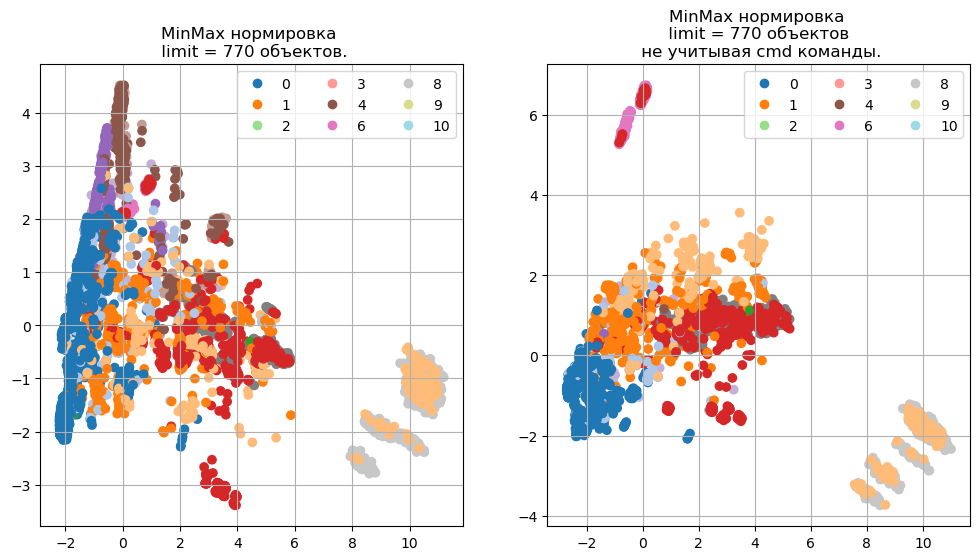

In [20]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1 = plot_2d(
    ax1,
    X=X_770_scaled_minmax,
    Y=y_770,
    commands=commands_770,
    obfuscation_combinations=methods_combinations_770,
    reduction_transformer=PCA,
    title=f"MinMax нормировка \n limit = {limit} объектов."
)

ax2 = plot_2d(
    ax2,
    X=X_770_without_cmd_scaled_minmax,
    Y=y_770_without_cmd,
    commands=commands_770_without_cmd,
    obfuscation_combinations=methods_combinations_770_without_cmd,
    reduction_transformer=PCA,
    title=f"MinMax нормировка \n limit = {limit} объектов \n не учитывая cmd команды."
)

None

### С аннотациями

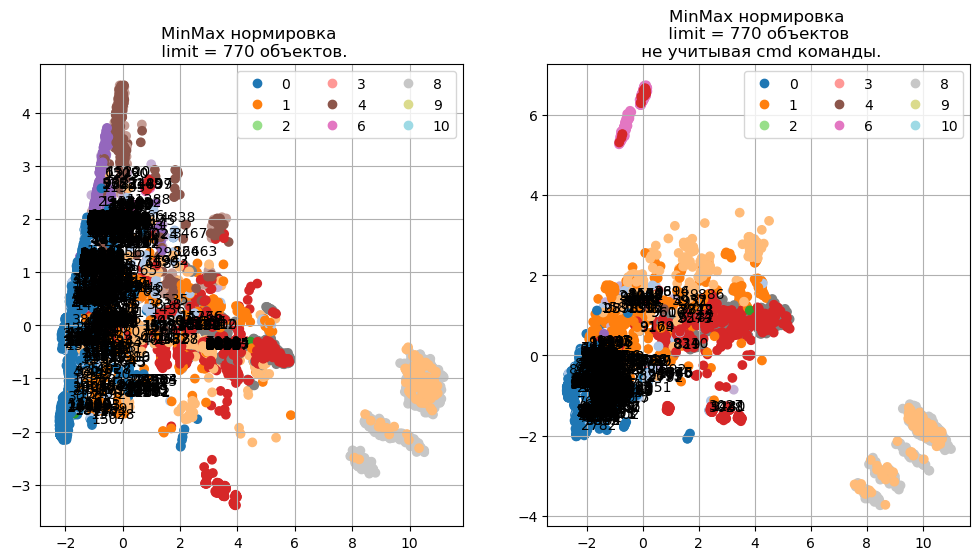

In [21]:
f, (ax3, ax4) = plt.subplots(1, 2, figsize=(12, 6))

ax3, overlapping_commands_770 = plot_2d(
    ax3,
    X=X_770_scaled_minmax,
    Y=y_770,
    commands=commands_770,
    obfuscation_combinations=methods_combinations_770,
    reduction_transformer=PCA,
    annotate=True,
    title=f"MinMax нормировка \n limit = {limit} объектов.",
    eps=0.05
)

ax4, overlapping_commands_770_without_cmd = plot_2d(
    ax4,
    X=X_770_without_cmd_scaled_minmax,
    Y=y_770_without_cmd,
    commands=commands_770_without_cmd,
    obfuscation_combinations=methods_combinations_770_without_cmd,
    reduction_transformer=PCA,
    annotate=True,
    title=f"MinMax нормировка \n limit = {limit} объектов \n не учитывая cmd команды.",
    eps=0.05
)

None

In [22]:
for correct_command, obf_command in overlapping_commands_770:
    print(correct_command, obf_command, sep='\n', end='\n\n')

Clear command № 1: $UserCredential = Get-Credential $Session = New-PSSession -ConfigurationName Microsoft.Exchange -ConnectionUri https://ps.outlook.com/powershell/ -Credential $LiveCred -Authentication Basic -AllowRedirection Import-PSSession $Session
Obfuscated command № 832: $UserCredential = Get-C`rede`ntial $Session = New-PSSession -ConfigurationName Microsoft.Exchange -ConnectionUri https://ps.outlook.com/powershell/ -Credential $LiveCred -Authentication Basic -AllowRedirection Import-PSSession $Session

Clear command № 62: Get-Service | Export-CSV c:\service.csv
Obfuscated command № 834: ${Us`erCred`ential} = Get-Credential ${Ses`s`ion} = New-PSSession -ConfigurationName Microsoft.Exchange -ConnectionUri https://ps.outlook.com/powershell/ -Credential ${L`i`veCred} -Authentication Basic -AllowRedirection Import-PSSession ${Se`s`sion}

Clear command № 1: $UserCredential = Get-Credential $Session = New-PSSession -ConfigurationName Microsoft.Exchange -ConnectionUri https://ps.outloo

In [23]:
for correct_command, obf_command in overlapping_commands_770_without_cmd:
    print(correct_command, obf_command, sep='\n', end='\n\n')

Clear command № 1: $UserCredential = Get-Credential $Session = New-PSSession -ConfigurationName Microsoft.Exchange -ConnectionUri https://ps.outlook.com/powershell/ -Credential $LiveCred -Authentication Basic -AllowRedirection Import-PSSession $Session
Obfuscated command № 799: $UserCredential = Get-C`rede`ntial $Session = New-PSSession -ConfigurationName Microsoft.Exchange -ConnectionUri https://ps.outlook.com/powershell/ -Credential $LiveCred -Authentication Basic -AllowRedirection Import-PSSession $Session

Clear command № 197: C:\Program Files (x86)\PHP\v5.5\php-cgi.exe
Obfuscated command № 801: ${Us`erCred`ential} = Get-Credential ${Ses`s`ion} = New-PSSession -ConfigurationName Microsoft.Exchange -ConnectionUri https://ps.outlook.com/powershell/ -Credential ${L`i`veCred} -Authentication Basic -AllowRedirection Import-PSSession ${Se`s`sion}

Clear command № 1: $UserCredential = Get-Credential $Session = New-PSSession -ConfigurationName Microsoft.Exchange -ConnectionUri https://ps.o

In [24]:
print(len(overlapping_commands_770))
print(len(overlapping_commands_770_without_cmd))

1247
810
